<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/main/Assignments/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 3

**Submission deadline:**
* **lab session in the week 27.11-1.12 2023**

**Points: 1+2+3=6 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com).

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [ ]:
!python3 -m pip install -q gdown httpimport

In [1]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

In [2]:
# Repeat notebook initialization and data loading

import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
import seaborn as sns
import matplotlib.pyplot as plt

iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Categorical(iris.target_names[iris.target])

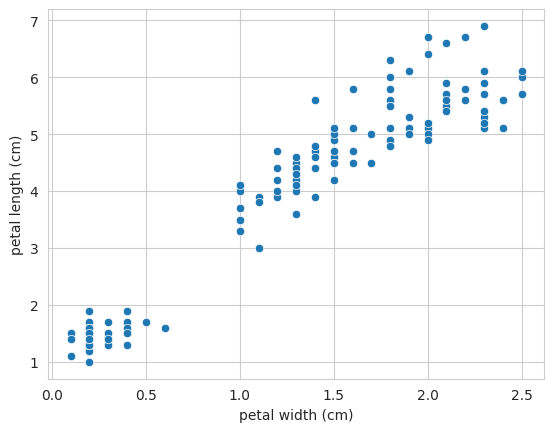

In [ ]:
reg_feature='petal width (cm)'
reg_target='petal length (cm)'

# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})


# Problem 1 [1p] Linear Regression

In [ ]:
class LinearRegression:
    def __init__(self):
        self.Theta = [None, None] # bias / weights vector

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        # calculate pseudoinverse of X
        X_pinv = np.linalg.pinv(X)
        # calculate Theta as product of X_pinv and y
        self.Theta = np.dot(X_pinv, y)

    # Y = aX + b
    def predict(self, X):
        return np.dot(X, self.Theta[1]) + self.Theta[0]


In [ ]:
X = iris_df[[reg_feature]]
y = iris_df[reg_target]

In [ ]:
model = LinearRegression()
model.fit(X,y)

In [ ]:
model.Theta

array([1.08355803, 2.2299405 ])

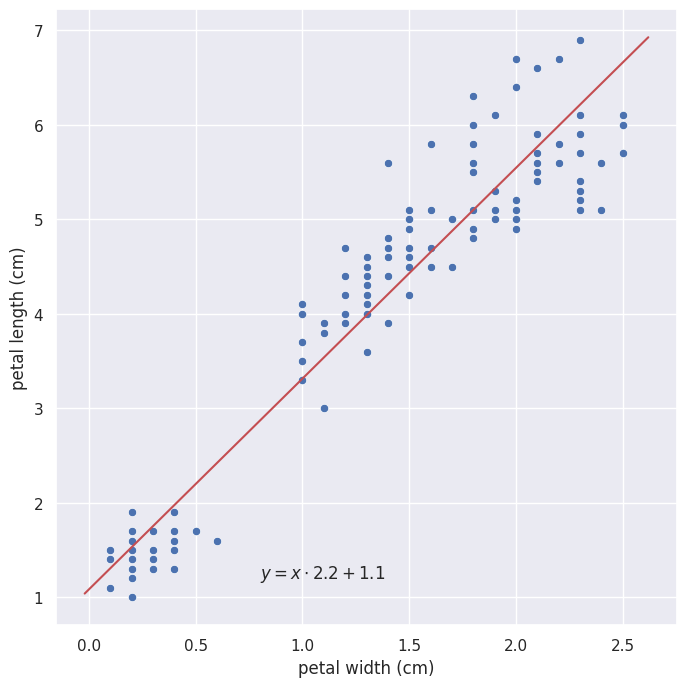

In [ ]:
# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = model.Theta[1] * length_bounds + model.Theta[0]

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$y = x \cdot {float(model.Theta[1]):0.2} + {float(model.Theta[0]):0.2}$")

# Problem 2 PolyRegression

Consider the following dataet which is created by the following probabilistic model:



1. $x \sim U[0,1]$: first $x$ is sampled uniformly from the  $[0,1]$ range.
2. $y \sim 1+2x-5x^2 + 4x^3 + \mathcal{N}(\mu=0, \sigma=0.1)$: then
    $y$ is a polynomial of $x$ plus random noise sampled from the Normal distribution with mean
    $\mu=0$ and standard deviation $0.1$


In [3]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#

true_poly_theta = np.array(
    [1.0, 2.0, -5, 4]
)

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1)
    Y = XP @ Theta.reshape(-1, 1)
    return Y

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1))
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y



np.random.seed(0)
train_data = make_dataset(30)


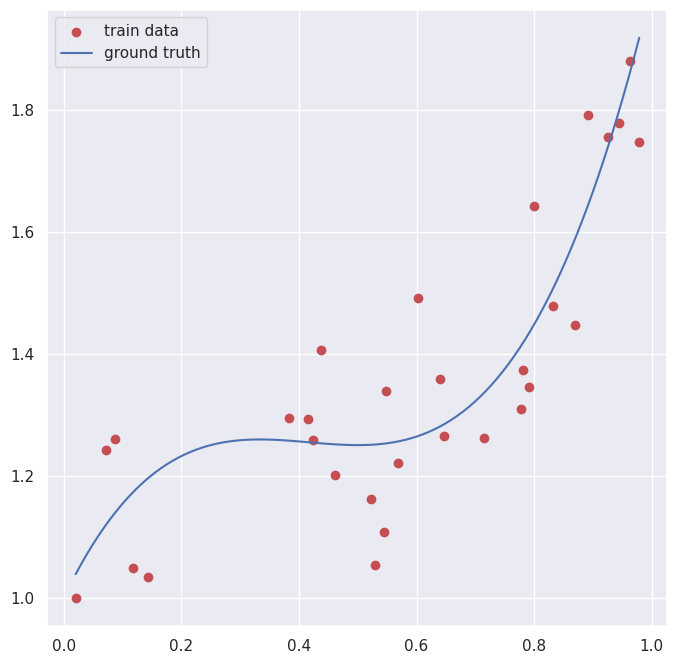

In [ ]:
XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

## Problem 2.1 [1p] Implement class `PolynomialRegression` numerically unstable

Directly apply the formula $$\Theta = (X^T X) ^{-1} X^T Y$$ as in the iris case, which fits a polynomial of a given degree. Use `np.linalg.inv` as the inverse operator. The output may be numerically unstable and may look as below.

In [ ]:
class PolynomialRegressionUnstable:
    def __init__(self, deg):
        self.deg = deg
        self.Theta = np.array([]) # bias / weights vector

    def prep(self, X):
        j = 0 # initialize a counter for the columns of X
        wsk = 1 # initialize an index for the columns of x2
        x2=np.insert(X,0,1,axis=1) # insert a column of ones to the left of X
        while (j<X.shape[1]): # loop over the columns of X
            kol = x2[:,wsk] # get the current column of x2
            akt = np.multiply(kol, kol) # square the column element-wise
            wsk += 1
            for i in range(1, self.deg):
                x2= np.insert(x2,wsk,akt,axis=1) # insert the squared column to x2
                wsk += 1
                akt = np.multiply(kol,akt) # multiply the column by the original column
            j+=1
        return x2 # return the modified matrix

    def fit(self, X, y):
        x2 = self.prep(X)
        self.Theta = np.linalg.inv( x2.T @ x2 ) @ x2.T @ y

    def predict(self, X):
        x2 = self.prep(X)
        return x2 @ self.Theta

In [4]:
def mse(y_true, y_pred):
    return ((y_pred - y_true)**2).mean()

MSE: 6.456090046938934


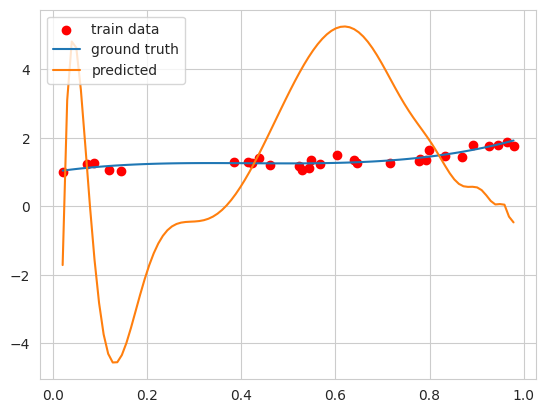

In [ ]:
X, y = train_data[0], train_data[1]

model = PolynomialRegressionUnstable(deg=50)
model.fit(X,y)
y_pred = model.predict(X)
print("MSE:", mse(y, y_pred))
XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)

plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, model.predict(XX), label="predicted")
plt.legend(loc="upper left")

The above plot shouldn't look like that --- since we have 30 points and a polynomial of degree 50, it should fit points almost perfectly. Still, it's quite clear that too big of a degree overfits the data.

## Problem 2.2 [1p] Implement class `PolynomialRegression` numerically stable

In the formula $$\Theta = (X^T X) ^{-1} X^T Y$$ the expression $$(X^T X) ^{-1} X^T $$ is sometimes called the Moore-Penrose Inverse. Computing it directly can sometimes be problematic due to numerical errors, but there are dedicated functions that compute it better.
Hence, apply the formula $$\Theta = (X^T X) ^{-1} X^T Y$$ but this time use `np.linalg.pinv`, i.e., the Moore-Penrose inverse directly. The output should be more like the one below.

In [ ]:
class PolynomialRegressionStable:
    def __init__(self, deg):
        self.deg = deg
        self.Theta = np.array([]) # bias / weights vector

    def prep(self, X):
        j = 0 # initialize a counter for the columns of X
        wsk = 1 # initialize an index for the columns of x2
        x2=np.insert(X,0,1,axis=1) # insert a column of ones to the left of X
        while (j<X.shape[1]): # loop over the columns of X
            kol = x2[:,wsk] # get the current column of x2
            akt = np.multiply(kol, kol) # square the column element-wise
            wsk += 1
            for i in range(1, self.deg): # loop from 1 to the degree of the polynomial
                x2= np.insert(x2,wsk,akt,axis=1) # insert the squared column to x2
                wsk += 1
                akt = np.multiply(kol,akt) # multiply the column by the original column
            j+=1
        return x2 # return the modified matrix

    def fit(self, X, y):
        x2 = self.prep(X)
        self.Theta = np.linalg.pinv( x2 ) @ y

    def predict(self, X):
        x2 = self.prep(X)
        return x2 @ self.Theta

In [ ]:
X, y = train_data[0], train_data[1]

model = PolynomialRegressionStable(deg=50)
model.fit(X,y)
y_pred = model.predict(X)
print("MSE:", mse(y, y_pred))

MSE: 0.001771155369992072


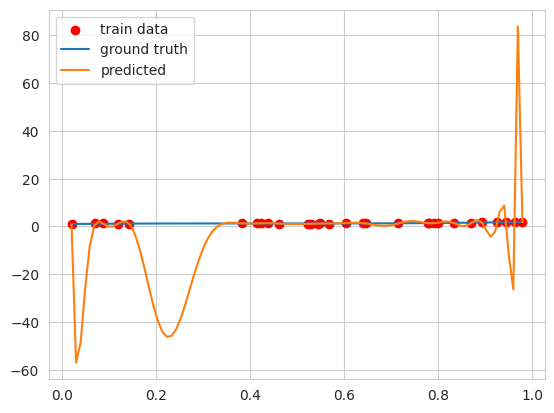

In [ ]:
XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)

plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, model.predict(XX), label="predicted")
plt.legend(loc="upper left")

# Problem 3 Regularized PolyRegression

As you can see above, the polynomial regression is prone to overfitting.
One way of dealing with it is Ridge type of regularization.
In this case the function which measures the fitness of the model is

$$ J_{\mbox{reg}}(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 +  \frac{\alpha}{N} \sum_j \Theta_j^2 = \text{MSE} + \text{Regularization}$$



## Problem 3.1 [1p] Closed form solution for $\Theta$

Without the regularization the closed form formula for $\Theta$ was $\Theta = (X^T X) ^{-1} X^T Y$ as shown during the lecture. Adopt the same line of math to get the closed form formula for $\Theta$ which minimizes $J_{\mbox{reg}}$.



To find the minimum, we need to take the derivative of Jreg with respect to $\Theta$ and set it to zero. Using the chain rule and the fact that the derivative of $Θj^2$ is $2*Θj$, we get:

$\frac{\partial Jreg}{\partial \Theta} = \frac{2}{N} \sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)(-x^{(i)}) + \frac{2\alpha}{N} \sum_j \Theta_j = 0 $

Rearranging the terms and multiplying both sides by $\frac{N}{2}$, we get:

$\sum_{i=1}^Nx^{(i)}(y^{(i)}-x^{(i)}\Theta) = \alpha \sum_j \Theta_j$

We can write this equation in matrix form as:

$X^T(Y - X\Theta) = \alpha \Theta$

$X^TY = X^TX \Theta + \alpha \Theta$

$\Theta(X^TX + \alpha I) = X^TY$

Finally, we end up with:

$\Theta = (X^TX + \alpha I)^{-1} X^TY$

## Problem 3.2 [1p] Implement PolyRidgeRegression

**Remark** use the `np.linalg.inv` cause the Moore-Penrose `np.linalg.pinv` is hard to apply here. We may allow for numerical unstability here, because the regularization term will fix a bit the problems itself. So use similar code as in `PolynomialRegressionUnstable`.

In [ ]:
class PolyRidgeRegression:
    def __init__(self, deg, alpha):
        self.deg = deg
        self.alpha = alpha
        self.Theta = np.array([]) # bias / weights vector

    def prep(self, X):
        j = 0 # initialize a counter for the columns of X
        wsk = 1 # initialize an index for the columns of x2
        x2=np.insert(X,0,1,axis=1) # insert a column of ones to the left of X
        while (j<X.shape[1]): # loop over the columns of X
            kol = x2[:,wsk] # get the current column of x2
            akt = np.multiply(kol, kol) # square the column element-wise
            wsk += 1
            for i in range(1, self.deg): # loop from 1 to the degree of the polynomial
                x2= np.insert(x2,wsk,akt,axis=1) # insert the squared column to x2
                wsk += 1
                akt = np.multiply(kol,akt) # multiply the column by the original column
            j += 1
        return x2 # return the modified matrix

    def fit(self, X, y):
        # Main method that fits the polynomial ridge regression model to the data
        XX = self.prep(X) # transform the input matrix into a matrix of polynomial features

        N = XX.shape[1]
        self.Theta = np.linalg.inv(XX.T @ XX + self.alpha * np.identity(N)) @ XX.T @ y

    def predict(self, X):
        XX = self.prep(X)
        # Calculate the predictions as Y = XX @ Theta, where Theta is the vector of coefficients
        # Note that the bias is the first element of Theta, and the weights are the rest
        y_pred = XX @ self.Theta
        # Return the predictions as a numpy array
        return y_pred

In [ ]:
X, y = train_data[0], train_data[1]

MSE: 6.456090046938934


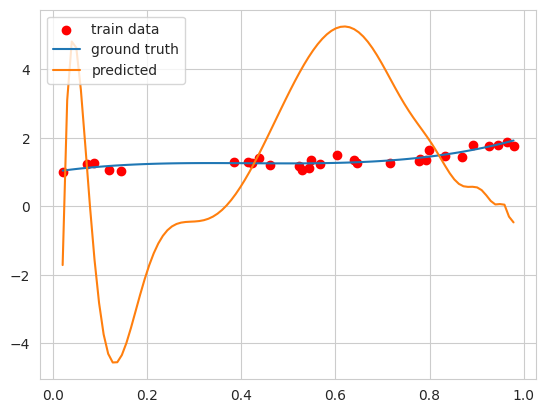

In [ ]:
#with alpha=0 it's without the regularization,
#due to the lack of numerical stability of our simple algorithm
#the image below that you will obtain can be funky and different from the one posted in the assignment
#point being, don't worry about the alpha=0 case, we want your algorithm to work for proper alphas

model = PolyRidgeRegression(deg=50, alpha=0)

model.fit(X,y)
y_pred = model.predict(X)
print("MSE:",mse(y, y_pred))


XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, model.predict(XX), label="predicted")
plt.legend(loc="upper left")

MSE: 0.01506703461516015


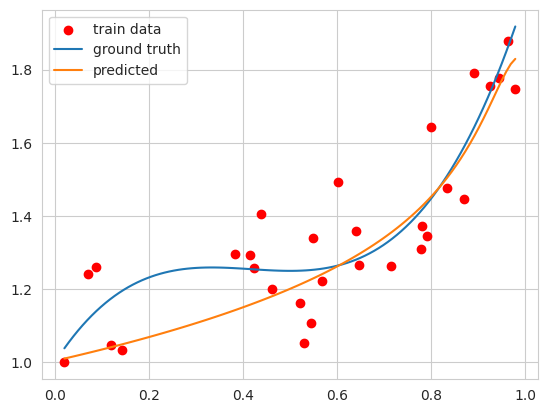

In [ ]:
model = PolyRidgeRegression(deg=50, alpha=1.) #with alpha=1 you can see already a better fit

model.fit(X,y)
y_pred = model.predict(X)
print("MSE:",mse(y, y_pred))


XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, model.predict(XX), label="predicted")
plt.legend(loc="upper left")

## Problem 3.3 [1p] finding best alpha and degree

Perform leave one out error estimation on the `train_data` to get the best $(d, \alpha)$ pair out of $\alpha \in \{0., 0.1, 0.5, 1., 5, 10, 50, 100, 500\}$ and $d \in \{1, 2, 4, 16, 32, 64\}$. The the error is measured via MSE.

MSE: 1.4981916798828183


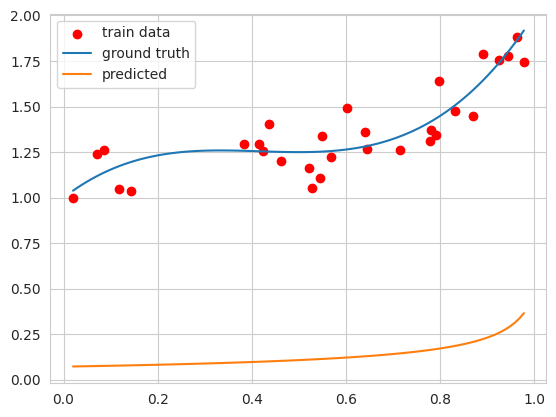

In [ ]:
model = PolyRidgeRegression(deg=64, alpha=500)

model.fit(X,y)
y_pred = model.predict(X)
print("MSE:",mse(y, y_pred))


XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, model.predict(XX), label="predicted")
plt.legend(loc="upper left")

In [ ]:
def loo(X, y, deg, alpha):
    errors = [] # list of errors for each left element
    n = X.shape[0] # number of elements
    for i in range(n): # perform loo for each element
        # create train and test set
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        X_test = X[i:i+1, :]
        y_test = y[i:i+1]
        model = PolyRidgeRegression(deg, alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = mse(y_test, y_pred)
        errors.append(error)
    mean_error = np.mean(errors)
    return mean_error

# searches for pair <deg, alpha> that has lowest mean error
def find_best_pair(X, y, degs, alphas):
    best_pair = None
    best_pair_error = None

    for deg in degs:
        for alpha in alphas:
            error = loo(X, y, deg, alpha)
            if best_pair is not None: # not first pair, compare with best
                if error < best_pair_error: # new best pair so far
                    best_pair = (deg, alpha)
                    best_pair_error = error
            else: # first pair, must be best so far
                best_pair = (deg, alpha)
                best_pair_error = error
    return best_pair, best_pair_error

degs = [1, 2, 4, 16, 32, 64]
alphas = [0., 0.1, 0.5, 1., 5, 10, 50, 100, 500]

best_pair, best_pair_error = find_best_pair(X, y, degs, alphas)

print(f"Best MSE was {best_pair_error} for degree {best_pair[0]} and alpha {best_pair[1]}")

Best MSE was 0.015830485025395916 for degree 64 and alpha 0.1
